# Naive implementation of the dense XPCS correlator

The function describing the XPCS calculation are described in 
http://dx.doi.org/10.1063/1.1287637
Eq 16 contains the error propagation.

This notebook describes:
1. The generation of a synthetic qmask and dense XPCS dataset
2. The calculation of a CSR representation of qbin mask
3. The calculation the reference results using a simple kernel without atomic operation on the device
4. The calculation of XPCS dataset using workgroup-wide collective reduction.

The performances are in peer with a good linear algebra implementation using a parallel BLAS but it is easier to follow the loops in OpenCL.

In [1]:
%matplotlib notebook
from matplotlib.pyplot import subplots
import os, time, sys
start_time = time.perf_counter()

## Qbin mask creation

In [2]:
import numpy
y,x = numpy.ogrid[-100:101,-120:121]
r = (x**2+y**2)**0.5
shape = r.shape
qbin = (r//10).astype(int)
shape

(201, 241)

<IPython.core.display.Javascript object>


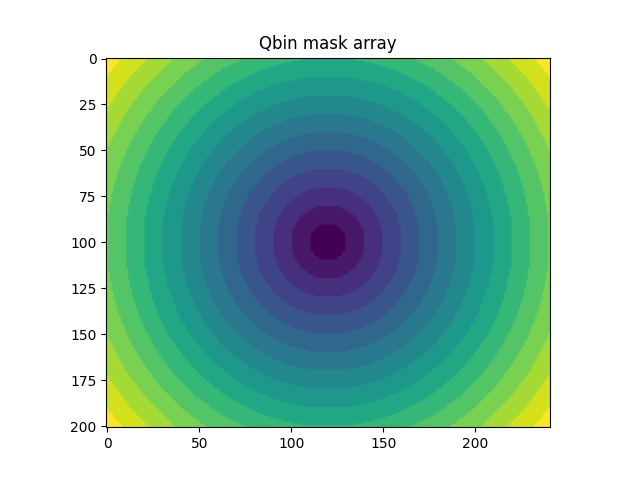

In [3]:
fig,ax = subplots(1, 1)
ax.imshow(qbin)
_=ax.set_title("Qbin mask array")

## CSR representation of the Qbin mask

In [4]:
%%time
pixel_cnt = numpy.bincount(qbin.ravel())
mask_ptr = numpy.concatenate(([0], pixel_cnt.cumsum()))
nbins = qbin.max()+1
positions = numpy.arange(nbins)

CPU times: user 334 µs, sys: 147 µs, total: 481 µs
Wall time: 317 µs


In [5]:
%time
from scipy.sparse import csc_matrix
row = numpy.digitize(qbin.ravel(), positions)-1
size = row.size
col = numpy.arange(size)
dat = numpy.ones(size, dtype=float)
csc = csc_matrix((dat, (row, col)), shape = (nbins, size))
print(csc.shape)

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 4.29 µs
(16, 48441)


In [6]:
%time csr = csc.tocsr()

CPU times: user 1.85 ms, sys: 807 µs, total: 2.66 ms
Wall time: 2.13 ms


In [7]:
csr.indptr

array([    0,   305,  1245,  2809,  5013,  7825, 11277, 15361, 20069,
       25433, 31397, 36843, 41755, 45185, 47205, 48241, 48441],
      dtype=int32)

## Creation of a fake XPCS dataset

<IPython.core.display.Javascript object>


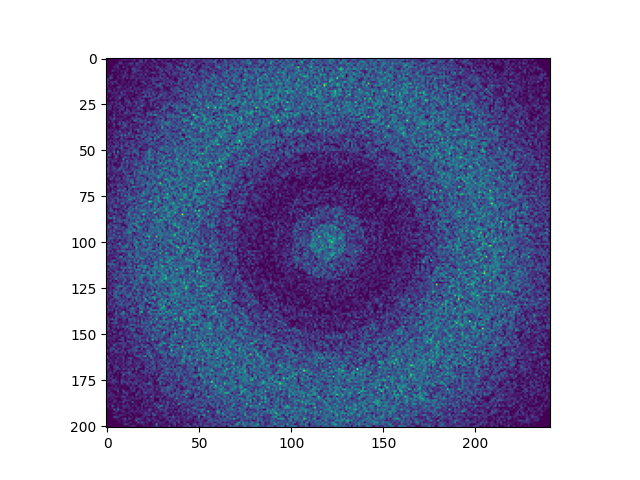

CPU times: user 1.74 s, sys: 67.4 ms, total: 1.8 s
Wall time: 1.8 s


In [8]:
%%time
nframes = 500
I0 = 10
frame = I0*(r.max()-r)/r.max()
frames = numpy.empty((nframes,)+ shape)
for q in range(qbin.max()):
    msk = qbin==q
    frames[:,msk] = numpy.outer(0.5*(numpy.sin(q*numpy.linspace(0, 100, nframes))+1.0), frame[msk])+1
# frames = numpy.fromfunction(lambda t,r: t*)outer(numpy.sin(numpy.linspace(0, 100, nframes))+1, frame.ravel()).reshape((nframes,)+r.shape)
stack = numpy.random.poisson(frames).astype("uint8")
#stack = numpy.ascontiguousarray(frames, dtype="uint8")
fig,ax = subplots()
ax.imshow(stack[499])

## Reference implementation based on numpy

In [9]:
from dynamix.correlator import dense
d=dense.MatMulCorrelator(shape, nframes, qmask=qbin)
%time res = d.correlate(stack, calc_std=True)

/users/kieffer/.venv/py39/lib/python3.9/site-packages/skcuda/cublas.py:284: UserWarning: creating CUBLAS context to get version number
  warnings.warn('creating CUBLAS context to get version number')


CPU times: user 6.01 s, sys: 4.71 s, total: 10.7 s
Wall time: 984 ms


/users/kieffer/.venv/py39/lib/python3.9/site-packages/dynamix/correlator/dense.py:64: RuntimeWarning: invalid value encountered in float_scalars
  res[i] = np.sum(dia_n) / np.sum(dia_d)
/users/kieffer/.venv/py39/lib/python3.9/site-packages/dynamix/correlator/dense.py:66: RuntimeWarning: invalid value encountered in true_divide
  dev[i] = np.std(dia_n / dia_d) / sqrt(len(dia_d))


# Implement dense correlator in OpenCL...

In [10]:
%load_ext pyopencl.ipython_ext

In [11]:
import pyopencl  as cl
from pyopencl import array as cla

ctx = cl.create_some_context(interactive=0)
queue = cl.CommandQueue(ctx, properties=cl.command_queue_properties.PROFILING_ENABLE)
print(f"Working on {ctx.devices[0].name}")

Working on GeForce GTX TITAN


In [12]:
%%cl_kernel
/*

  Naive implementation of the dense correlator.
  =============================================  

Size of the kernel: 2D 
    dim0: qbin  groupsize: 1 or more
    dim1: tau   groupsize: 1 or more     

Constrains:
  No collaboration between treads.
  No shared memory
  No constrains on workgroup size
  Requires double-precision floating point unit

Parameters:
        frames: 3D array, stack of SAXS frames
        q_mask_ptr: 1D array with indexes of start of qbin in q_mask_pixels
        q_mask_pixels: 1d array with indexes of pixel contributing in qbin
        output_mean: 2d array (qbin, tau) with XPCS result
        output_stc: 2d array (qbin, tau) with deviation of XPCS result
        Nt: number of time-steps recorded
        image_size: width*height

References: 
    Variance propagation implemented according to doi:10.1145/3221269.3223036
*/


kernel void correlator_multiQ_dense(
                                    const global char* frames,
                                    const global int* q_mask_ptr,
                                    const global int* q_mask_pixels,
                                    global float* output_mean,
                                    global float* output_std,
                                    const int Nt,
                                    const int image_size) {
    uint qbin = get_global_id(0);
    uint tau = get_global_id(1);
    if (tau >= Nt) return;
    
    const int start = q_mask_ptr[qbin+1];
    const int stop = q_mask_ptr[qbin+2];
    const int npix = stop - start;
    
    ulong dia_n_sum = 0;
    double dia_d_sum = 0.0;
    
    double sumV = 0.0;  // sum of values
    double varV = 0.0;  // sum on variance contribution
    uint cnt = 0;       // sum of weights, i.e counter
    for (uint t = tau; t < Nt; t++) {
        ulong sum1 = 0;
        ulong sum2 = 0;
        ulong dia_n_val = 0;
        for (uint idx = start; idx < stop; idx++) {
            uint pix_idx = q_mask_pixels[idx];
            uint val1 = frames[t*image_size + pix_idx];
            uint val2 = frames[(t-tau)*image_size + pix_idx];
            dia_n_val += val1 * val2;
            sum1 += val1;
            sum2 += val2;
        }
        double dia_d_val = sum1 * sum2 * 1.0 / (npix * npix);
        
        dia_n_sum += dia_n_val;
        dia_d_sum += dia_d_val;
        
        //Variance propagation
        double val = dia_n_val / (dia_d_val * npix);
        if (cnt>0){
            double num = sumV - cnt*val;
            varV += num*num/(cnt*(cnt+1));
        }
        sumV += val;        
        cnt++;
    }
    uint pos = qbin*Nt + tau;
    output_mean[pos] = dia_n_sum * 1.0 / (dia_d_sum * npix);
    output_std[pos] = sqrt(varV) / cnt;
}


In [13]:
d_frames = cla.to_device(queue, stack)
d_q_mask_ptr = cla.to_device(queue, csr.indptr)
d_q_mask_pix = cla.to_device(queue, csr.indices)
d_avg = cla.zeros(queue, (nbins-1,nframes), dtype="float32")
d_std = cla.zeros(queue, (nbins-1,nframes), dtype="float32")
t0 = time.perf_counter()
evt = correlator_multiQ_dense(queue, (nbins-1, (nframes+31)//32*32), (1,32),
                            d_frames.data,
                            d_q_mask_ptr.data,
                            d_q_mask_pix.data,
                            d_avg.data,
                            d_std.data,
                            numpy.int32(nframes),
                            numpy.int32(qbin.size))

In [14]:
evt.wait()
print(f"Execution time as measured from Python: {1000*(time.perf_counter()-t0):.3f}ms and OpenCL: {(evt.profile.end-evt.profile.start)*1e-6:.3f}ms")

Execution time as measured from Python: 2572.622ms and OpenCL: 2572.139ms


<IPython.core.display.Javascript object>


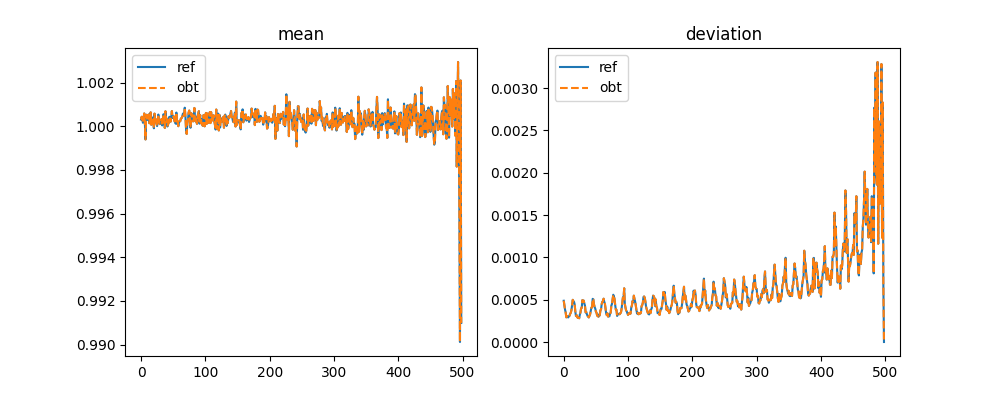

In [15]:
fig, ax = subplots(1, 2, figsize=(10,4))
bin = 1
ax[0].plot(res[0][bin][1:], label="ref")
ax[0].plot(d_avg.get()[bin][1:], "--", label="obt")
ax[0].legend()
ax[0].set_title("mean")
ax[1].plot(res[1][bin][1:], label="ref")
ax[1].plot(d_std.get()[bin][1:], "--", label="obt")
ax[1].set_title("deviation")
_=ax[1].legend()

## Perfrom the azimuthal regrouping and then use collective reduction

In this approach, the array is first re-organized to have pixels from the same Qbin grouped together to make memory access more efficient.

In a second kernel, collective reads and reduction are used to speed up execution

The drawback is that this approach almost duplicates the memory needed on the device.

In [16]:
%%cl_kernel
/*
    Kernel re-ordering the pixel in each slice so that they are contiguous
    ======================================================================

Pixel with qmask=0 are discarded.

Size of the kernel: 3D 
    dim0: Collaborative threads writing
    dim1: qbin  groupsize: 1
    dim2: tau   groupsize: 1

Constrains:
  Collaborative writing
  No shared memory
  No constrains on workgroup size

Parameters:
        frames: 3D array, stack of SAXS frames
        q_mask_ptr: 1D array with indexes of start of qbin in q_mask_pixels
        q_mask_pixels: 1d array with indexes of pixel contributing in qbin
        Nt: number of time-steps recorded
        nbin: number of bins in mask
        image_size: width*height
        output: 3D array, stack of SAXS frames with pixel re-ordered.

*/
kernel void multiQ_reorder(    const global char* frames,
                               const global int* q_mask_ptr,
                               const global int* q_mask_pixels,
                               const int Nt,
                               const int nbin,
                               const int image_size,
                               global char* output){
    const uint tid = get_local_id(0);
    const uint ws = get_local_size(0);
    const uint qbin = get_global_id(1);
    const uint tau = get_global_id(2);
    
    // Barrier for thread index: bin0 is discarded
    if (tau >= Nt) return;
    if (qbin == 0) return; 
    if (qbin >= nbin) return;
    
    const int start = q_mask_ptr[qbin];
    const int stop = q_mask_ptr[qbin+1];
    const int npix = stop - start;
    const int offset = q_mask_ptr[1];
    const int nb_pix = q_mask_ptr[nbin] - offset; // number of (valid) pixels in a frame
    
    for (int idx = start+tid; idx<stop; idx+=ws) {
        output[tau*nb_pix + idx - offset] = frames[tau*image_size + q_mask_pixels[idx]];
    }
}

In [17]:
d_ordered = cla.zeros(queue, (nframes, csr.indptr[-1]-csr.indptr[1]), dtype=stack.dtype)
wg = 128
print((wg, nbins, nframes))
t0 = time.perf_counter()
evt = multiQ_reorder(queue, (wg, nbins, nframes), (wg, 1, 1),
                    d_frames.data,
                    d_q_mask_ptr.data,
                    d_q_mask_pix.data,
                    numpy.int32(nframes),
                    numpy.int32(nbins),
                    numpy.int32(qbin.size),
                    d_ordered.data)

evt.wait()
print(f"Reorder execution time: {1000*(time.perf_counter()-t0):.3f} ms, in OpenCL: {(evt.profile.end-evt.profile.start)*1e-6:.3f} ms")


(128, 16, 500)
Reorder execution time: 1.203 ms, in OpenCL: 0.919 ms


In [18]:
%%cl_kernel -o "-DWG=128"
/*

  Collaborative implementation of the dense correlator
  ====================================================

Size of the kernel: 
    dim0: collaborative read/reduction workgoup size: 128 
    dim1: qbin  groupsize: 1
    dim2: tau   groupsize: 1

Constrains:
      Collaboration between treads in dim0, expected WG threads.
      Workgroup size should be at least the size of a memory transaction and limited by the amount of shared memory
      Shared memory: 3x WG * sizeof(uint)
      Requires double-precision floating point unit

Parameters:
        frames: 3D array, stack of SAXS frames
        q_mask_ptr: 1D array with indexes of start of qbin in q_mask_pixels
        output_mean: 2d array (qbin, tau) with XPCS result
        output_stc: 2d array (qbin, tau) with deviation of XPCS result
        Nt: number of time-steps recorded
        nbin: Number of bins in qbin mask

References: 
    Variance propagation implemented according to doi:10.1145/3221269.3223036
*/

#ifndef WG
#define WG 1024
#endif

// Sum-up all elements in 3 arrays, reset themt, and return the sum of each of them
inline uint3 summed3(local uint* ary1,
                     local uint* ary2,
                     local uint* ary3){
    uint wg = get_local_size(0);
    const uint tid = get_local_id(0);
    barrier(CLK_LOCAL_MEM_FENCE);
    while (wg>1){
        wg /= 2;
        if (tid<wg){
            ary1[tid] += ary1[tid+wg];
            ary2[tid] += ary2[tid+wg];
            ary3[tid] += ary3[tid+wg];
        }
        if (wg>32)
            barrier(CLK_LOCAL_MEM_FENCE);
    }
    uint3 value = (uint3)(ary1[0], ary2[0], ary3[0]);
    barrier(CLK_LOCAL_MEM_FENCE);
    ary1[tid] = 0;
    ary2[tid] = 0;
    ary3[tid] = 0;
    barrier(CLK_LOCAL_MEM_FENCE);
    return value;
}


kernel void correlator_multiQ_ordered(
                                    const global char* frames,
                                    const global int* q_mask_ptr,
                                    global float* output_mean,
                                    global float* output_std,
                                    const int Nt,
                                    const int nbin) {
    const uint qbin = get_global_id(1);
    const uint tau = get_global_id(2);
    const uint tid = get_local_id(0);
    const uint ws = get_local_size(0);
    // Barrier for thread index
    if (tau >= Nt) return;
    if (qbin == 0) return;
    if (qbin >= nbin) return;
    if (ws>WG){
        if (tid==0){
            printf("Actual workgroup size %d is larger than allocated memory %s\n",ws, WG);
        }
        return;
    }
    const int offset = q_mask_ptr[1];
    const int nb_pix = q_mask_ptr[nbin] - offset;
    const int start = q_mask_ptr[qbin] - offset;
    const int stop = q_mask_ptr[qbin+1] -offset;
    const int npix = stop - start;
    
    ulong dia_n_sum = 0;
    double dia_d_sum = 0.0;
    
    //Shared arrays
    local uint shared_sum1[WG];
    local uint shared_sum2[WG];
    local uint shared_dia_n_val[WG];
    shared_sum1[tid] = 0;
    shared_sum2[tid] = 0;
    shared_dia_n_val[tid] = 0;
    barrier(CLK_LOCAL_MEM_FENCE);
    
    double sumV = 0.0;  // sum of values
    double varV = 0.0;  // sum on variance contribution
    uint cnt = 0;       // sum of weights, i.e counter
    for (uint t = tau; t < Nt; t++) {
        ulong sum1 = 0;
        ulong sum2 = 0;
        ulong dia_n_val = 0;
        for (uint idx = start+tid; idx < stop; idx+=ws) {
            uint val1 = frames[t*nb_pix + idx];
            uint val2 = frames[(t-tau)*nb_pix + idx];
            shared_dia_n_val[tid] += val1 * val2;
            shared_sum1[tid] += val1;
            shared_sum2[tid] += val2;
        }
        uint3 partial_sum = summed3(shared_dia_n_val, shared_sum1, shared_sum2);
        dia_n_val = partial_sum.s0;
        sum1 = partial_sum.s1;
        sum2 = partial_sum.s2;
        
        if (tid==0){
            double dia_d_val = 1.0 * sum1 * sum2 / (npix * npix);

            dia_n_sum += dia_n_val;
            dia_d_sum += dia_d_val;

            //Variance propagation
            double val = dia_n_val / (dia_d_val * npix);
            if (cnt>0){
                double num = sumV - cnt*val;
                varV += num*num / (cnt*(cnt+1));
            }
            sumV += val;        
            cnt++;
        }
    }
    if (tid==0){
        uint pos = (qbin-1)*Nt + tau;
        output_mean[pos] = dia_n_sum * 1.0 / (dia_d_sum * npix);
        output_std[pos] = sqrt(varV) / cnt;
    }
}


In [19]:
wg = 128
d_avg = cla.zeros(queue, (nbins-1, nframes), dtype="float32")
d_std = cla.zeros(queue, (nbins-1, nframes), dtype="float32")
t0 = time.perf_counter()
evt = correlator_multiQ_ordered(queue, (wg, nbins, nframes), (wg, 1,1),
                                d_ordered.data,
                                d_q_mask_ptr.data,
                                d_avg.data,
                                d_std.data,
                                numpy.int32(nframes),
                                numpy.int32(csr.indptr.size-1)
                               )
evt.wait()
print(f"multiQ_ordered execution time: {1000*(time.perf_counter()-t0):.3f} ms, in OpenCL: {(evt.profile.end-evt.profile.start)*1e-6:.3f} ms")


multiQ_ordered execution time: 236.906 ms, in OpenCL: 236.342 ms


<IPython.core.display.Javascript object>


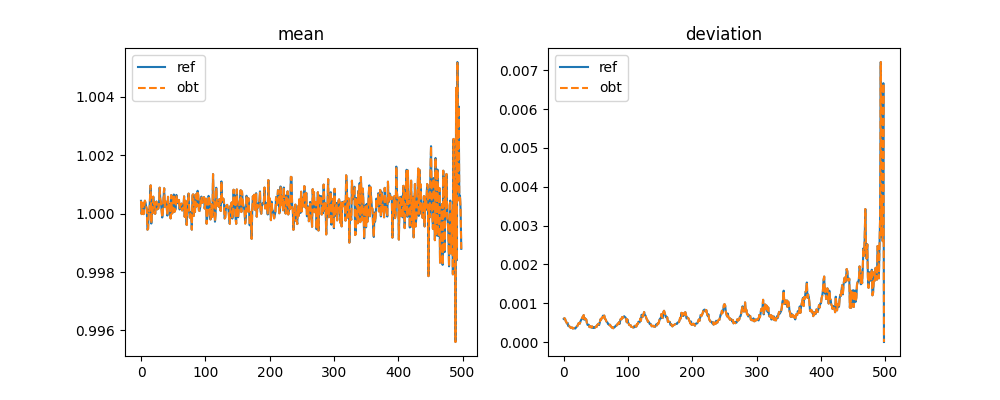

In [20]:
fig, ax = subplots(1, 2, figsize=(10,4))
bin = 0
ax[0].plot(res[0][bin][1:], label="ref")
ax[0].plot(d_avg.get()[bin][1:], "--", label="obt")
ax[0].legend()
ax[0].set_title("mean")
ax[1].plot(res[1][bin][1:], label="ref")
ax[1].plot(d_std.get()[bin][1:], "--", label="obt")
ax[1].set_title("deviation")
_=ax[1].legend()

## Conclusions
The presents notebook some the implementation of two dense correlators: 

1. a naive correlator which is the direct implementation of the formula with loops. It is about 2.5x slower than the BLAS implementation using numpy.
2. To gain some speed, pixel are re-organized to have those of a same bin adjacent in memory. Like this, the execution time is now 4x faster than the BLAS implementation.

Execution time depends a lot of the size of the problem and the generation of the GPU used. The `Titan` used in this experiment lasts from 2013 and is especially bad at scattered reads, thus bad for this experiment.

In [21]:
print(f"Total execution time: {time.perf_counter()-start_time:.3f} s")

Total execution time: 7.095 s
